In [ ]:
import torch
import torchvision.transforms.functional as F
import torchvision.models.detection as detection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import time

# Load the Faster R-CNN model with ResNet50 backbone, pre-trained on COCO dataset
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights

In [ ]:
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = detection.fasterrcnn_resnet50_fpn(weights=weights)
model.eval()  # Set model to evaluation mode

# Fetch COCO class names
COCO_CLASSES = weights.meta["categories"]

# List of images to process
images = [
    "Pigs.jpg",
    "Race_Horse.jpeg",
    "Randy_Moss.jpeg",
    "Team_USA.jpeg",
    "Bayern.jpeg",
    "Byron_Buxton.jpeg"
]

# Initialize a list to store results for all images
detection_results = []

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 92.2MB/s]


In [ ]:
# Set a confidence threshold
confidence_threshold = 0.5

# Process each image
for img_name in images:
    # Load the image
    image = Image.open(img_name)
    image_tensor = F.to_tensor(image)

    # Perform object detection and measure time
    start_time = time.time()
    with torch.no_grad():
        predictions = model([image_tensor])
    end_time = time.time()
    detection_time = end_time - start_time

    # Extract predictions
    predicted_boxes = predictions[0]['boxes']
    predicted_scores = predictions[0]['scores']
    predicted_labels = predictions[0]['labels']

    # Filter predictions by confidence threshold
    object_names = []
    confidence_scores = []
    for score, label in zip(predicted_scores, predicted_labels):
        if score >= confidence_threshold:
            class_name = weights.meta["categories"][label.item()]
            object_names.append(f"{class_name} ({round(score.item() * 100, 2)}%)")
            confidence_scores.append(score.item())

    # Calculate average confidence score
    average_confidence = sum(confidence_scores) / len(confidence_scores) if confidence_scores else 0

    # Save results
    detection_results.append({
        "Image": img_name,
        "Total Objects Detected": len(object_names),
        "Detection Time (s)": round(detection_time, 2),
        "Average Confidence (%)": round(average_confidence * 100, 2),
        "Detected Objects": ", ".join(object_names)
    })

# Create a DataFrame summarizing the results
summary_df = pd.DataFrame(detection_results)

# Save and display results
print(summary_df)
summary_df.to_csv("faster_rcnn_summary.csv", index=False)

               Image  Total Objects Detected  Detection Time (s)  \
0           Pigs.jpg                       5                8.97   
1    Race_Horse.jpeg                       8                6.07   
2    Randy_Moss.jpeg                       9                7.78   
3      Team_USA.jpeg                      19                8.43   
4        Bayern.jpeg                      15                8.01   
5  Byron_Buxton.jpeg                       3                6.47   

   Average Confidence (%)                                   Detected Objects  
0                   69.09  cow (87.48%), cow (79.17%), sheep (65.12%), bi...  
1                   93.85  horse (99.9%), person (99.45%), horse (99.08%)...  
2                   86.17  person (99.94%), person (99.8%), person (99.73...  
3                   82.73  person (99.9%), person (99.86%), person (99.8%...  
4                   85.49  person (99.92%), person (99.82%), person (99.7...  
5                   86.09  person (99.98%), baseb

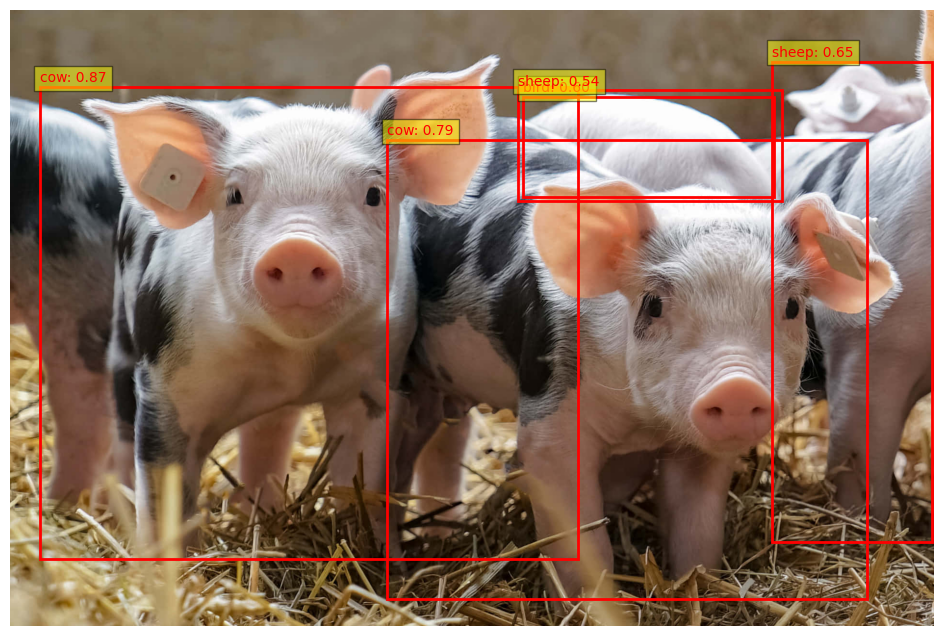

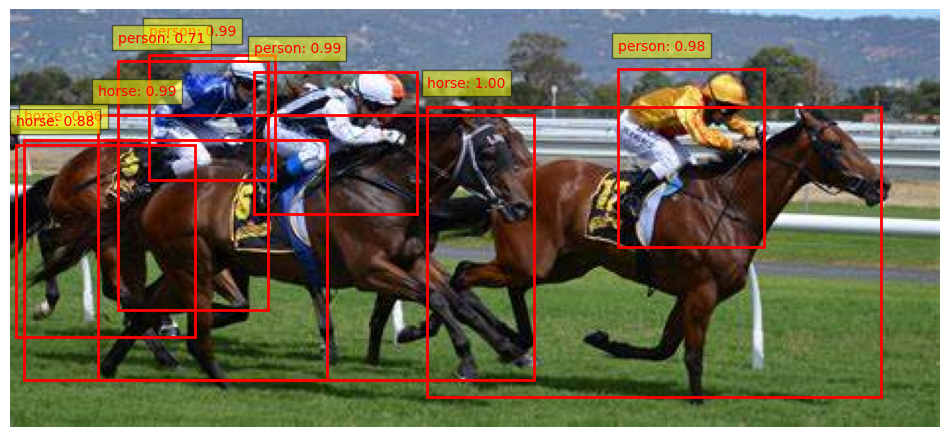

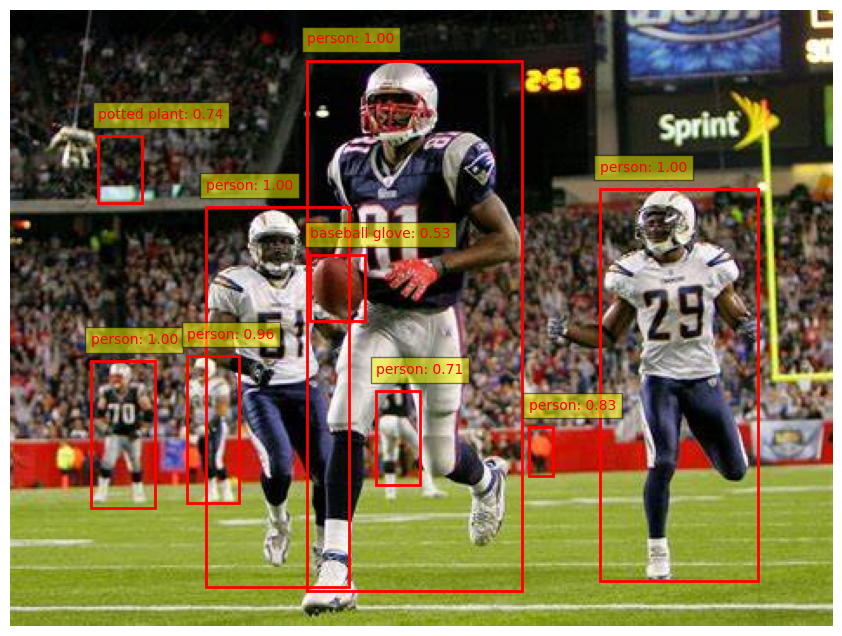

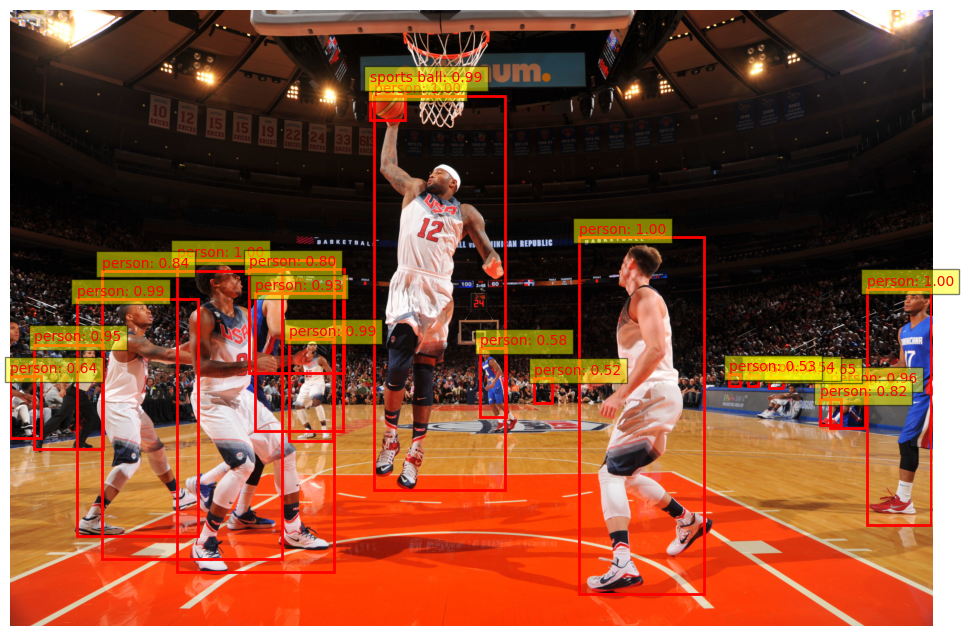

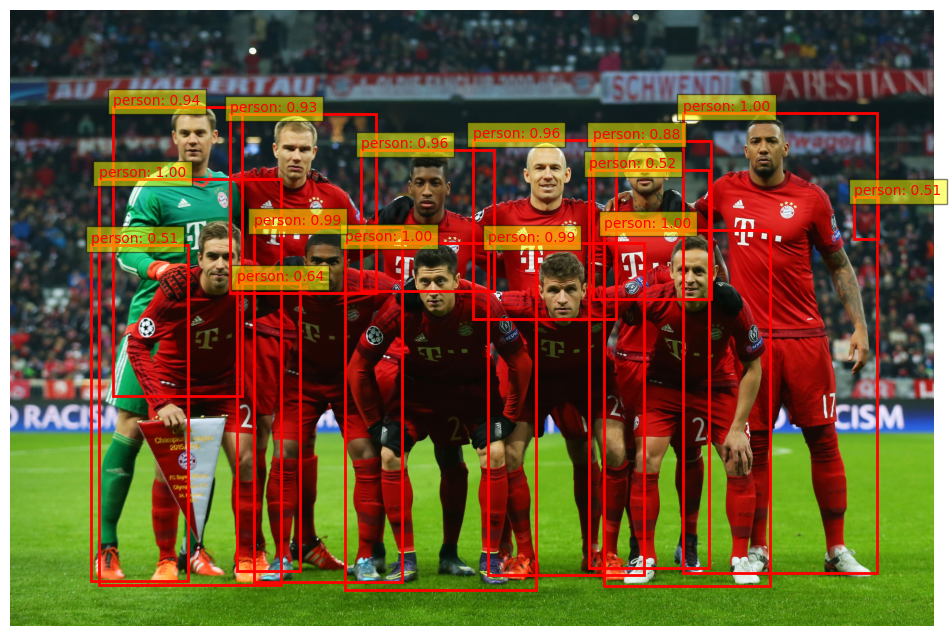

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Function to visualize the image with detections
def visualize_detections(image_path, boxes, labels, scores, confidence_threshold, class_names):
    image = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    for box, label, score in zip(boxes, labels, scores):
        if score >= confidence_threshold:
            # Draw bounding box
            x1, y1, x2, y2 = box.tolist()
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Add label and confidence score
            class_name = class_names[label.item()]
            text = f"{class_name}: {score:.2f}"
            ax.text(x1, y1 - 10, text, color='red', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Display detections for each image
for result in detection_results:
    image_path = result["Image"]
    predictions = model([F.to_tensor(Image.open(image_path))])
    boxes = predictions[0]['boxes']
    scores = predictions[0]['scores']
    labels = predictions[0]['labels']

    visualize_detections(image_path, boxes, labels, scores, confidence_threshold, COCO_CLASSES)

